In [1]:
import pandas as pd
#To ensure that all columns are displayed in the output
pd.set_option('display.max_columns', None)


Build Daily Target (Next-Day Close)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

df = pd.read_csv(r"C:\Users\allif\Downloads\Crypto_stocks\data\processed\predictive_coins_merged.csv", parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.head()

,Date,BTC_open,BTC_high,BTC_low,BTC_close,BTC_volume,ETH_open,ETH_high,ETH_low,ETH_close,ETH_volume,LTC_open,LTC_high,LTC_low,LTC_close,LTC_volume,Gold_open,Gold_high,Gold_low,Gold_close,Gold_volume
0,2020-08-28,11330.38,11542.65,11276.89,11526.91,45953.908365,383.31,398.00,379.75,395.11,7.326015e+05,56.12,58.28,55.33,57.38,644522.18905,1945.95,2049.69,1945.95,1977.99,105.408271
1,2020-08-29,11526.90,11580.02,11417.04,11465.84,32973.799200,395.10,405.69,391.88,398.65,6.598026e+05,57.36,58.18,56.93,56.97,408492.18575,1966.91,1989.91,1940.01,1964.34,191.835869
2,2020-08-30,11465.84,11719.00,11458.00,11711.16,43177.879054,398.65,429.89,398.30,428.94,8.949797e+05,56.95,62.95,56.93,62.89,839317.10194,1972.16,1985.00,1946.75,1982.10,260.892030
3,2020-08-31,11711.17,11800.77,11570.00,11649.51,55353.617744,428.94,439.00,418.04,433.79,1.040749e+06,62.89,63.70,60.51,60.92,680146.78621,1982.10,1983.65,1964.39,1971.48,131.651537
4,2020-09-01,11649.51,12050.85,11515.00,11921.97,78148.193668,433.80,488.84,429.03,475.40,1.751355e+06,60.94,64.31,59.69,62.69,972744.47944,1971.48,2007.50,1967.31,1981.25,200.684098


Initial Exploration

In [3]:
# Basic info
print(df.info())
print(df.describe())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Show the time span
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1792 non-null   datetime64[ns]
 1   BTC_open     1792 non-null   float64       
 2   BTC_high     1792 non-null   float64       
 3   BTC_low      1792 non-null   float64       
 4   BTC_close    1792 non-null   float64       
 5   BTC_volume   1792 non-null   float64       
 6   ETH_open     1792 non-null   float64       
 7   ETH_high     1792 non-null   float64       
 8   ETH_low      1792 non-null   float64       
 9   ETH_close    1792 non-null   float64       
 10  ETH_volume   1792 non-null   float64       
 11  LTC_open     1792 non-null   float64       
 12  LTC_high     1792 non-null   float64       
 13  LTC_low      1792 non-null   float64       
 14  LTC_close    1792 non-null   float64       
 15  LTC_volume   1792 non-null   float64       
 16  Gold_o

Exploratory Data Analysis (EDA)

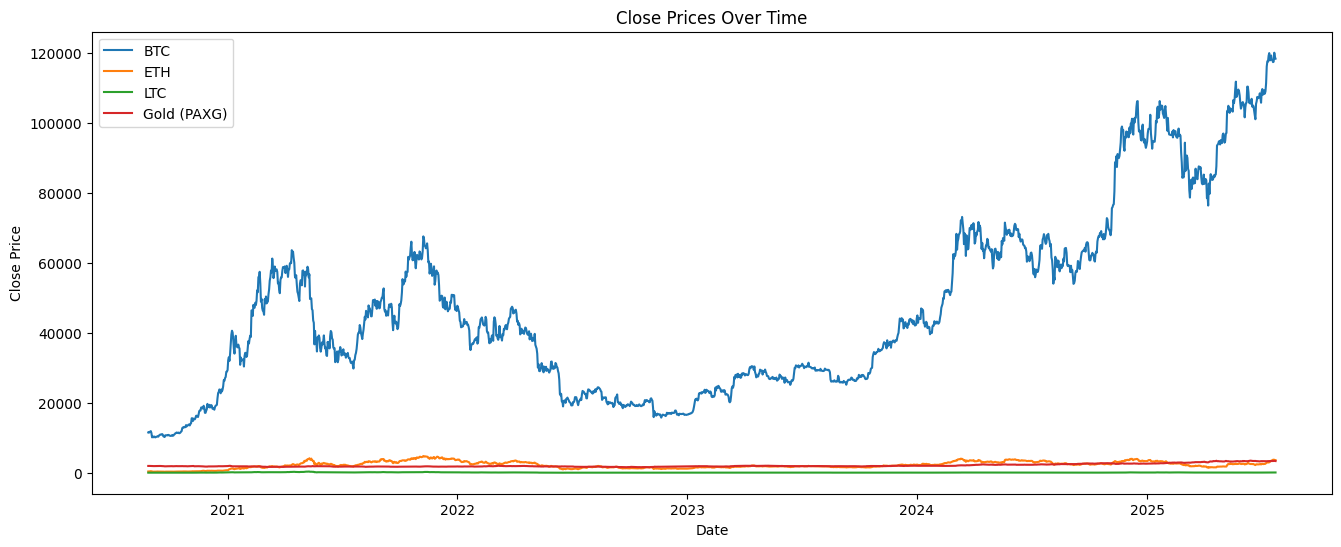

In [5]:
# Visaulising the close price of each coin
plt.figure(figsize=(16,6))
plt.plot(df['Date'], df['BTC_close'], label='BTC')
plt.plot(df['Date'], df['ETH_close'], label='ETH')
plt.plot(df['Date'], df['LTC_close'], label='LTC')
plt.plot(df['Date'], df['Gold_close'], label='Gold (PAXG)')
plt.legend()
plt.title('Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

Correlation Analysis

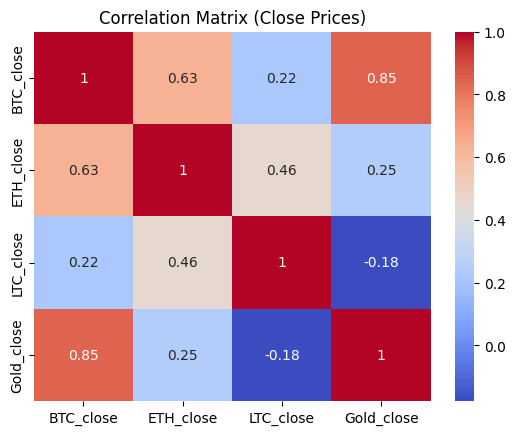

In [6]:
import seaborn as sns
# Correlation matrix for close prices
close_prices = df[['BTC_close','ETH_close','LTC_close','Gold_close']]
sns.heatmap(close_prices.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Close Prices)")
plt.show()


Stationarity & Log Returns


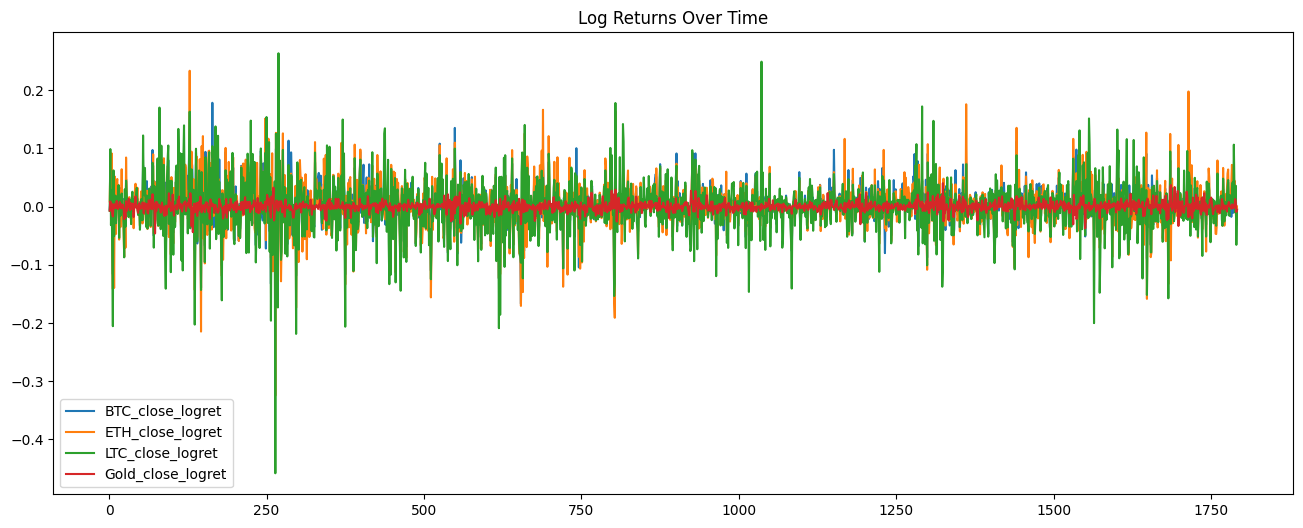

In [7]:
for col in ['BTC_close','ETH_close','LTC_close','Gold_close']:
    df[f'{col}_logret'] = np.log(df[col] / df[col].shift(1))

df[[f'{col}_logret' for col in ['BTC_close','ETH_close','LTC_close','Gold_close']]].dropna().plot(figsize=(16,6))
plt.title("Log Returns Over Time")
plt.show()


Handle Outliers

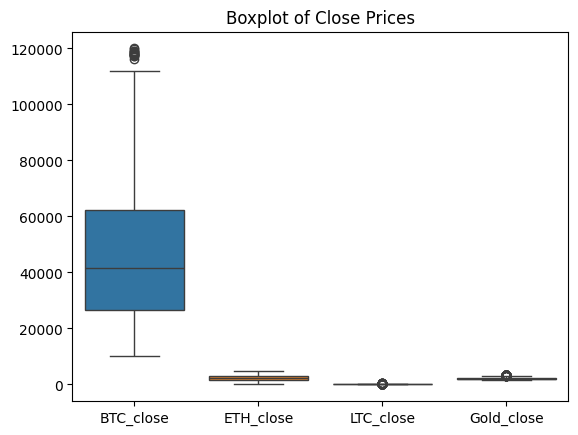

In [8]:
# Visualize outliers
sns.boxplot(data=close_prices)
plt.title("Boxplot of Close Prices")
plt.show()


Scaling (for Deep Learning)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[[c for c in df.columns if '_close' in c]])
scaled_df = pd.DataFrame(scaled_features, columns=[f"{c}_scaled" for c in df.columns if '_close' in c])

In [12]:
# Include the date column
scaled_df_with_date = df[['Date']].reset_index(drop=True).join(scaled_df)

# Save with date included
scaled_df_with_date.to_csv(
    r"C:\Users\allif\Downloads\Crypto_stocks\data\processed\scaled_predictive_coins.csv", 
    index=False
)

In [13]:
import joblib

# Save the scaler
joblib.dump(scaler, 'minmax_scaler_close_prices.pkl')

['minmax_scaler_close_prices.pkl']